# RDKit workshop

In the following, RDKit will be applied to explore a chemical dataset (Delaney) on the solubility of various substances in water (logS(mol/L)).

### Part 1: Data loading and exploration

Inspect the dataset and visualise the solubility distribution (EDA). Tasks:
- How many compounds are in the dataset?
- What is the average and range of the solubility values in the dataset?
- Are there extreme outliers (e.g. box plot)?

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("delaney.csv")
display(df)
print(df["logS"].min(), df["logS"].max(), '\n', df['logS'].mean(), df['logS'].std())  
display(df.describe()) # optional: df['logS'].describe() to just describe an explicit column
# unique compounds:
print(len(df['Compound ID'].unique()))
print(len(df['SMILES'].unique()))

,Compound ID,logS,SMILES
0,"1,1,1,2-Tetrachloroethane",-2.180,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.000,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.740,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.480,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.040,FC(F)(Cl)C(F)(Cl)Cl
...,...,...,...
1139,vamidothion,1.144,CNC(=O)C(C)SCCSP(=O)(OC)(OC)
1140,Vinclozolin,-4.925,CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C
1141,Warfarin,-3.893,CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O
1142,Xipamide,-3.790,Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O


-11.6 1.58 
 -3.0579973776223777 2.0965019290656026


,logS
count,1144.000000
mean,-3.057997
std,2.096502
min,-11.600000
25%,-4.332250
50%,-2.870500
75%,-1.600000
max,1.580000


1143
1128


# first few commands we do with every dataset
df.info()
df.describe() # summary statistics: big tail on the negative side (small solubility)

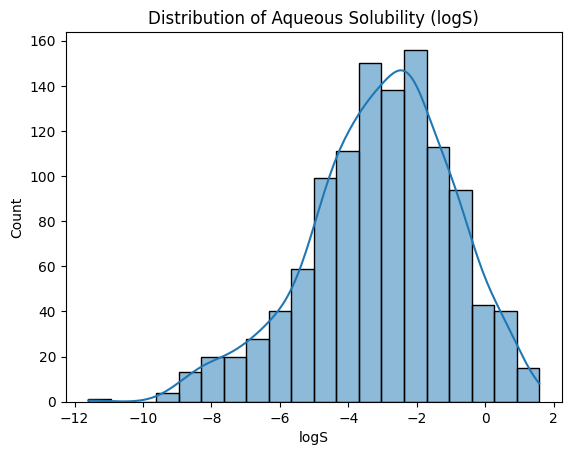

In [6]:

sns.histplot(df['logS'], bins=20, kde=True)
plt.title("Distribution of Aqueous Solubility (logS)")
plt.show()

<Axes: ylabel='logS'>

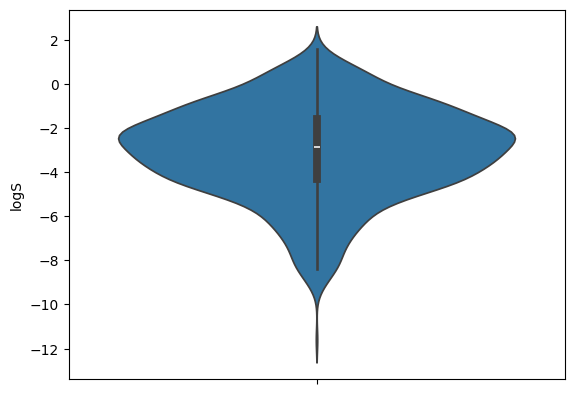

In [8]:
# look for outliers and symmetry
# reminder: only remoe outliers if you have a good reason to do so! here: hard to judge besides chemical intuition
sns.violinplot(df['logS'])

### Part 2: Compute descriptors with RDKit

Calculate molecular descriptors from the SMILES. See snippet below for the syntax of doing so.

Tasks:
- Compute 5-10 descriptors based on the SMILES (e.g. use the apply() method in pandas) and add them to the DataFrame
- Find out if there is any correlation of the descriptors and the solubility (e.g. plots)

Some info on available descriptors: 
- https://github.com/hypowergravity/RDKitDescriptorExamples-
- https://schwallergroup.github.io/practical-programming-in-chemistry/tutorials/lecture_05/02_rdkit_descriptors.html
- https://deepwiki.com/rdkit/rdkit/6.1-chemical-reactions#molecular-descriptors-and-properties

MD:
1st: long list of descriports. select roughly 10 descriptors and add them to the df. then find if some descriptors correlate with the solubilities.
use: MolWt, MolLogP, MaxPartialCharge, Phi(Flexibility Index), RingCount, NumHeterocycles, NumAmideBonds, fr_COO

In [35]:
from rdkit import Chem
from rdkit.Chem import Descriptors

# Syntax for deriving descriptors:
# 1) convert smiles to Mol: mol = Chem.MolFromSmiles(smiles)
# 2) derive descriptor, e.g. for MolWt: descr = Descriptors.MolWt(mol)

descr_list = ['MolWt', 'MolLogP', 'MaxPartialCharge', 'TPSA', 'SPS', 'NumHDonors', 'NumHAcceptors', 'Phi', 'RingCount', 'NumHeterocycles', 'NumAmideBonds', 'fr_COO']

def calc_descriptors(smiles, descr):
    mol = Chem.MolFromSmiles(smiles)
    return getattr(Descriptors, descr)(mol)

for descr in descr_list:
    df[descr] = df['SMILES'].apply(lambda s: calc_descriptors(s, descr)) # lambda function to pass smiles code and not whole series
df.head()

,Compound ID,logS,SMILES,MolWt,MolLogP,MaxPartialCharge,TPSA,SPS,NumHDonors,NumHAcceptors,Phi,RingCount,NumHeterocycles,NumAmideBonds,fr_COO,fingerprint,similarity,cluster,has_aromat
0,"1,1,1,2-Tetrachloroethane",-2.18,ClCC(Cl)(Cl)Cl,167.850,2.5954,0.203436,0.0,12.00,0,0,2.939419,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.076923,2,False
1,"1,1,1-Trichloroethane",-2.00,CC(Cl)(Cl)Cl,133.405,2.3765,0.187382,0.0,12.00,0,0,1.814285,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.090909,2,False
2,"1,1,2,2-Tetrachloroethane",-1.74,ClC(Cl)C(Cl)Cl,167.850,2.5938,0.137344,0.0,11.00,0,0,3.817823,0,0,0,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000000,2,False
3,"1,1,2-Trichloroethane",-1.48,ClCC(Cl)Cl,133.405,2.0289,0.120829,0.0,9.60,0,0,3.610448,0,0,0,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.076923,2,False
4,"1,1,2-Trichlorotrifluoroethane",-3.04,FC(F)(Cl)C(F)(Cl)Cl,187.375,2.9189,0.382976,0.0,14.25,0,0,2.294762,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000000,2,False


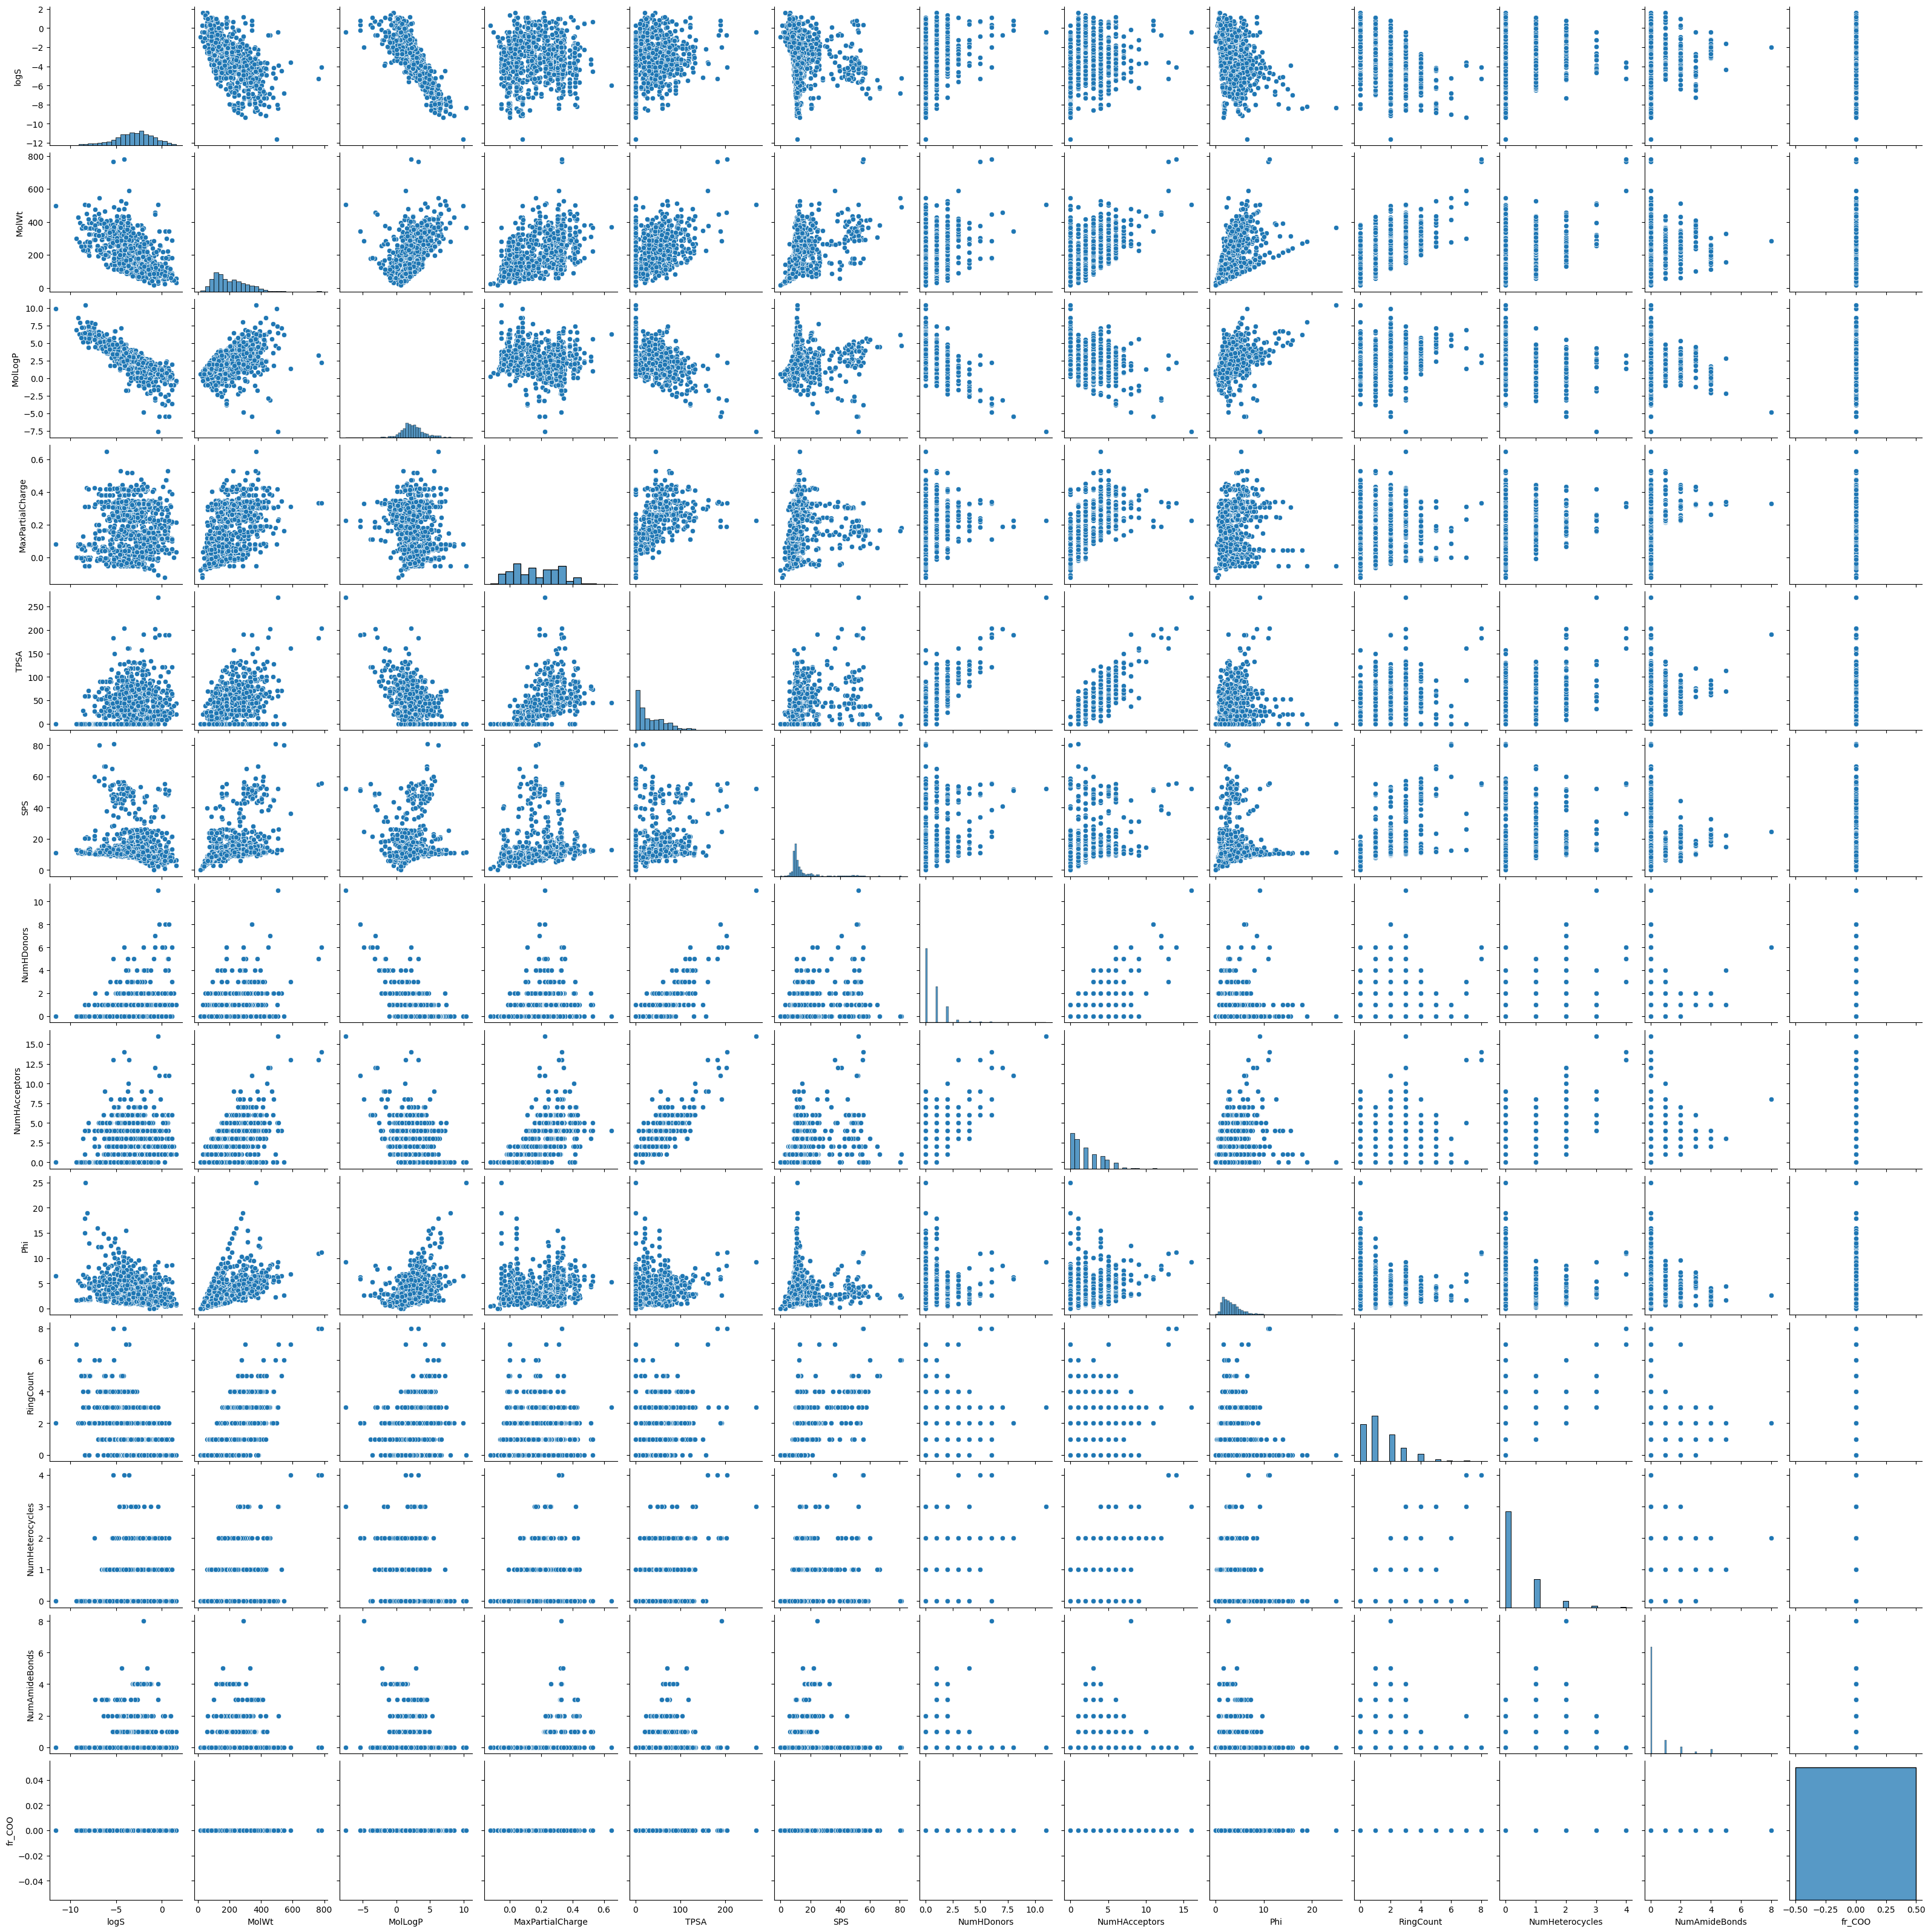

In [11]:
sns.pairplot(df)

### Part 3: Predict solubility (Regression Model)

Use the code below to predict the logS using a RandomForestRegressor:

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# separate training features X and target variable y
X = df.drop(columns=["logS", "Compound ID", "SMILES"], axis=1) # drop non-numeric columns and target (dependent) variable
display(X.head())
y = df["logS"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # pseudo-random state for reproducibility
model = RandomForestRegressor(n_estimators=200, random_state=42) # n_estimators: hyperparameters, e.g. number of trees
model.fit(X_train, y_train) # train the model with the fit function
pred = model.predict(X_test) # make predictions on the test set

# compare predictions to true values
print("R²:", r2_score(y_test, pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, pred)))
print("train accuracy:", model.score(X_train, y_train))
print("test accuracy:", model.score(X_test, y_test))

# high train accuracy and low test accuracy indicates slight overfitting

,MolWt,MolLogP,MaxPartialCharge,TPSA,SPS,NumHDonors,NumHAcceptors,Phi,RingCount,NumHeterocycles,NumAmideBonds,fr_COO
0,167.850,2.5954,0.203436,0.0,12.00,0,0,2.939419,0,0,0,0
1,133.405,2.3765,0.187382,0.0,12.00,0,0,1.814285,0,0,0,0
2,167.850,2.5938,0.137344,0.0,11.00,0,0,3.817823,0,0,0,0
3,133.405,2.0289,0.120829,0.0,9.60,0,0,3.610448,0,0,0,0
4,187.375,2.9189,0.382976,0.0,14.25,0,0,2.294762,0,0,0,0


R²: 0.9064273165967189
RMSE: 0.6383308153840671
train accuracy: 0.9856128393103358
test accuracy: 0.9064273165967189


Based on the EDA, which descriptors might influence the solubility the most?

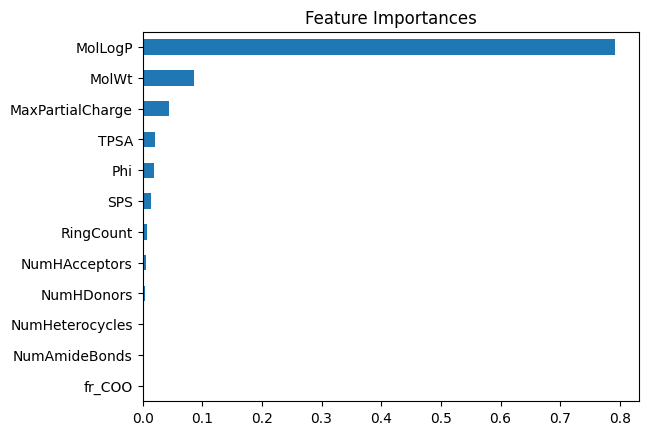

In [15]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.sort_values().plot(kind='barh')
plt.title("Feature Importances")
plt.show()

### Part 4: Similarity Search

Create fingerprints from the SMILES and add them to the dataframe.

In [38]:
from rdkit.Chem import rdFingerprintGenerator, DataStructs

# use e.g. the morgan FPG: mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)

# convert smiles to mol object, then use this in the fingerprint generator
def mol2fp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = mfpgen.GetFingerprint(mol)
    return fp

# apply is a super handy function to apply a function to each element in a series, can conveniently be combined with lambda functions
df["fingerprint"] = df["SMILES"].apply(mol2fp)
# version with lambda:
# df["fingerprint"] = df["SMILES"].apply(lambda s: mfpgen.GetFingerprint(Chem.MolFromSmiles(s)))
df.head()


,Compound ID,logS,SMILES,MolWt,MolLogP,MaxPartialCharge,TPSA,SPS,NumHDonors,NumHAcceptors,Phi,RingCount,NumHeterocycles,NumAmideBonds,fr_COO,fingerprint,similarity,cluster,has_aromat
0,"1,1,1,2-Tetrachloroethane",-2.18,ClCC(Cl)(Cl)Cl,167.850,2.5954,0.203436,0.0,12.00,0,0,2.939419,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.076923,2,False
1,"1,1,1-Trichloroethane",-2.00,CC(Cl)(Cl)Cl,133.405,2.3765,0.187382,0.0,12.00,0,0,1.814285,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.090909,2,False
2,"1,1,2,2-Tetrachloroethane",-1.74,ClC(Cl)C(Cl)Cl,167.850,2.5938,0.137344,0.0,11.00,0,0,3.817823,0,0,0,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000000,2,False
3,"1,1,2-Trichloroethane",-1.48,ClCC(Cl)Cl,133.405,2.0289,0.120829,0.0,9.60,0,0,3.610448,0,0,0,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.076923,2,False
4,"1,1,2-Trichlorotrifluoroethane",-3.04,FC(F)(Cl)C(F)(Cl)Cl,187.375,2.9189,0.382976,0.0,14.25,0,0,2.294762,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000000,2,False


Calculate the Tanimoto similarity of the molecules in the dataframe in comparison to a molecule of your choice (e.g. caffeine, aniline, ethanol).

In [39]:
query_fp = mol2fp("CN1C=NC2=C1C(=O)N(C(=O)N2C)C")
print(query_fp)

df["similarity"] = df["fingerprint"].apply(lambda fp: DataStructs.TanimotoSimilarity(fp, query_fp))
df.head()
df.describe()

,logS,MolWt,MolLogP,MaxPartialCharge,TPSA,SPS,NumHDonors,NumHAcceptors,Phi,RingCount,NumHeterocycles,NumAmideBonds,fr_COO,similarity,cluster
count,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000,1144.0,1144.000000,1144.000000
mean,-3.057997,204.631675,2.449133,0.170652,35.058829,14.679241,0.708916,2.116259,3.505139,1.396853,0.352273,0.377622,0.0,0.067665,1.329545
std,2.096502,102.620500,1.866003,0.141188,35.694546,11.111498,1.108335,2.165816,2.361926,1.316105,0.651423,0.932952,0.0,0.049719,0.769475
min,-11.600000,16.043000,-7.571400,-0.123544,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,-4.332250,122.126000,1.414900,0.046287,0.000000,9.412500,0.000000,0.000000,1.901825,0.000000,0.000000,0.000000,0.0,0.044444,1.000000
50%,-2.870500,183.594500,2.340300,0.155198,26.300000,10.558442,0.000000,2.000000,2.958543,1.000000,0.000000,0.000000,0.0,0.063661,1.000000
75%,-1.600000,270.715750,3.406475,0.302194,55.610000,13.913636,1.000000,3.000000,4.424487,2.000000,1.000000,0.000000,0.0,0.086394,2.000000
max,1.580000,780.949000,10.388600,0.646588,268.680000,80.952381,11.000000,16.000000,25.000000,8.000000,4.000000,8.000000,0.0,1.000000,3.000000


In [41]:
query_fp = mol2fp("Nc1ccccc1") # aniline
print(query_fp)

df["similarity"] = df["fingerprint"].apply(lambda fp: DataStructs.TanimotoSimilarity(fp, query_fp))
#df.head()
#df.describe()
df['similarity'].nlargest(10)

394     1.000000
910     0.466667
916     0.466667
440     0.428571
913     0.411765
920     0.411765
970     0.411765
783     0.400000
844     0.400000
1006    0.400000
Name: similarity, dtype: float64

In [20]:
query_fp = mol2fp("OCC")
print(query_fp)

df["similarity"] = df["fingerprint"].apply(lambda fp: DataStructs.TanimotoSimilarity(fp, query_fp))
df.describe()
df['similarity'].nlargest(10)

642    1.000000
114    0.555556
987    0.428571
66     0.416667
110    0.384615
209    0.384615
461    0.375000
141    0.363636
243    0.363636
77     0.357143
Name: similarity, dtype: float64

,Compound ID,SMILES
114,1-Propanol,CCCO


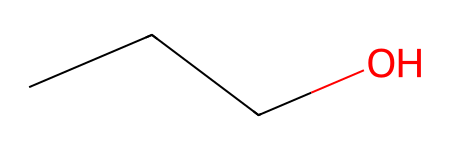

In [69]:
display(df.loc[[114], ["Compound ID", "SMILES"]])
ccco = Chem.MolFromSmiles(df["SMILES"][114])
ccco

### Part 5: Clustering molecules by strucutre

Use fingerprints to group molecules into clusters (using k-means clustering) and visualise via PCA. Tasks:
- Experiment with different numbers of clusters
- Compute the average solubility per cluster
- Do certain clusters correspond to highly or poorly soluble compounds?

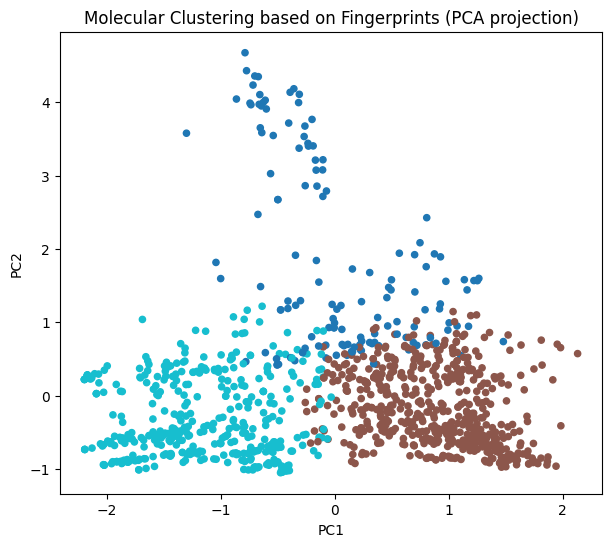

In [71]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

fps = df["fingerprint"].to_list()

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(fps)

# K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(fps)
df["cluster"] = clusters

# Visualize clusters
plt.figure(figsize=(7,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap="tab10", s=20)
plt.title("Molecular Clustering based on Fingerprints (PCA projection)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

In [72]:
print(df.groupby("cluster")["logS"].mean())

cluster
0   -4.041540
1   -3.574464
2   -2.094190
Name: logS, dtype: float64


In [73]:
df["has_aromat"] = df["SMILES"].apply(lambda s: Chem.MolFromSmiles(s).HasSubstructMatch(Chem.MolFromSmarts("a")))
pd.crosstab(df["cluster"], df["has_aromat"])

has_aromat,False,True
cluster,,
0,52,87
1,12,550
2,405,38


### Part 6: Substructure Search via SMARTS

Search for specific functional groups or chemical motifs within the dataset using SMARTS (SMiles ARbitrary Target Specification): e.g. alcohol = "[OX2H]", carboxylic acid = "C(=O)[OH]", aromatic compounds = "a", amines = "[NX3;H2,H1;!$(NC=O)]"

See here for a more detailed list of SMARTS: https://www.daylight.com/dayhtml/doc/theory/theory.smarts.html 

Tasks:
- Count how many molecules contain each functional group (method: Mol.HasSubstructMatch(SMARTS)).
- Compare average solubility for molecules with vs. without each substructure.
- Visualize with a bar plot.

In [119]:
from rdkit import Chem

patterns = {
    "hydroxyl": Chem.MolFromSmarts("[OX2H]"),
    "has_aromat": Chem.MolFromSmarts("a"),
    "ester_bond": Chem.MolFromSmarts("[CX3](=O)O")
}

for pat, calc in patterns.items():
    df[pat] = df["SMILES"].apply(lambda s: Chem.MolFromSmiles(s).HasSubstructMatch(calc))

df.head()


,Compound ID,logS,SMILES,MolWt,MolLogP,MaxPartialCharge,TPSA,SPS,NumHDonors,NumHAcceptors,...,NumHeterocycles,NumAmideBonds,fr_COO,fingerprint,similarity,cluster,has_aromat,hydroxyl,carboxylic_acid,ester_bond
0,"1,1,1,2-Tetrachloroethane",-2.18,ClCC(Cl)(Cl)Cl,167.850,2.5954,0.203436,0.0,12.00,0,0,...,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,2,False,False,False,False
1,"1,1,1-Trichloroethane",-2.00,CC(Cl)(Cl)Cl,133.405,2.3765,0.187382,0.0,12.00,0,0,...,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,2,False,False,False,False
2,"1,1,2,2-Tetrachloroethane",-1.74,ClC(Cl)C(Cl)Cl,167.850,2.5938,0.137344,0.0,11.00,0,0,...,0,0,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,2,False,False,False,False
3,"1,1,2-Trichloroethane",-1.48,ClCC(Cl)Cl,133.405,2.0289,0.120829,0.0,9.60,0,0,...,0,0,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,2,False,False,False,False
4,"1,1,2-Trichlorotrifluoroethane",-3.04,FC(F)(Cl)C(F)(Cl)Cl,187.375,2.9189,0.382976,0.0,14.25,0,0,...,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,2,False,False,False,False


In [120]:
df[df["ester_bond"]].loc[:, ["Compound ID", "SMILES"]]

,Compound ID,SMILES
272,3-Butanoyloxymethylphenytoin,O=C1N(COC(=O)CCC)C(=O)C(N1)(c2ccccc2)c3ccccc3
277,3-Ethanoyloxymethylphenytoin,O=C1N(COC(=O)C)C(=O)C(N1)(c2ccccc2)c3ccccc3
280,3-Heptanoyloxymethylphenytoin,O=C1N(COC(=O)CCCCCC)C(=O)C(N1)(c2ccccc2)c3ccccc3
283,3-Hexanoyloxymethylphenyltoin,O=C1N(COC(=O)CCCCC)C(=O)C(N1)(c2ccccc2)c3ccccc3
301,3-Octanoyloxymethylphenytoin,O=C1N(COC(=O)CCCCCCC)C(=O)C(N1)(c2ccccc2)c3ccccc3
...,...,...
1095,thiofanox,CNC(=O)ON=C(CSC)C(C)(C)C
1114,triamcinolone diacetate,CC(=O)OCC(=O)C3(O)C(CC4C2CCC1=CC(=O)C=CC1(C)C2...
1132,Trimazosin,COc2cc1c(N)nc(nc1c(OC)c2OC)N3CCN(CC3)C(=O)OCC(...
1140,Vinclozolin,CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C


In [121]:
df[list(patterns.keys())].sum()

hydroxyl      245
has_aromat    675
ester_bond    138
dtype: int64

In [122]:
for name in patterns.keys():
    print(df.groupby(name)["logS"].mean())

hydroxyl
False   -3.262195
True    -2.308718
Name: logS, dtype: float64
has_aromat
False   -2.285335
True    -3.594855
Name: logS, dtype: float64
ester_bond
False   -3.023364
True    -3.310471
Name: logS, dtype: float64


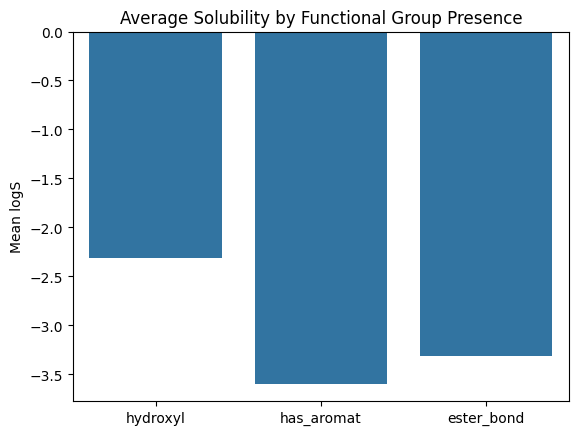

In [123]:
import seaborn as sns
means = {}

for name in patterns.keys():
    mean_series = df.groupby(name)["logS"].mean()
    if len(mean_series) > 1:
        val = mean_series.iloc[1]
        means[name] = val
    else:
        print(f"No {name} in dataset")

sns.barplot(x=list(means.keys()), y=list(means.values()))
plt.title("Average Solubility by Functional Group Presence")
plt.ylabel("Mean logS")
plt.show()